In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = torch.nn.Identity()
model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Using device: cuda


In [2]:
import glob
import os

base_video_path = 'hmdb51_org'
video_files = glob.glob(os.path.join(base_video_path, '**', '*.avi'), recursive=True)

if not video_files:
    print(f"경로('{base_video_path}')에서 .avi 파일을 찾을 수 없습니다.")
    print("압축이 풀린 폴더 구조를 확인하고 'base_video_path'를 수정하세요.")
else:
    print(f"총 {len(video_files)}개의 비디오 파일을 찾았습니다.")

총 6766개의 비디오 파일을 찾았습니다.


In [3]:
import cv2
import numpy as np
from PIL import Image
import torch.nn.functional as F

def get_frame_distances(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return []

    distances = []
    prev_embedding = None
    
    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            input_tensor = preprocess(image).unsqueeze(0).to(device)
            embedding = model(input_tensor)

            if prev_embedding is not None:
                sim = F.cosine_similarity(embedding, prev_embedding)
                distance = 1.0 - sim.item()
                distances.append(distance)
            
            prev_embedding = embedding

    cap.release()
    return distances

In [4]:
import numpy as np

def find_scenes_from_distances(distances, multiplier=3.5):
    scene_cuts = []
    if not distances or len(distances) < 2:
        return scene_cuts, 0

    distances_arr = np.array(distances)
    mean_dist = np.mean(distances_arr)
    std_dist = np.std(distances_arr)
    
    dynamic_threshold = mean_dist + (std_dist * multiplier)
    
    for i, dist in enumerate(distances):
        if dist > dynamic_threshold:
            scene_cuts.append(i + 1)
    
    return scene_cuts, dynamic_threshold

테스트 비디오 시작: The_Matrix_Revolutions_6_fall_floor_u_cm_np1_fr_bad_2.avi
  임베딩/거리 계산 완료 (총 44 프레임). 소요 시간: 0.53초
  씬 감지 완료. (동적 Threshold: 0.4844)
  총 1개의 씬 컷을 감지했습니다.
  컷 프레임 위치: [38]

--- 프레임 간 거리(변화량) 그래프 ---


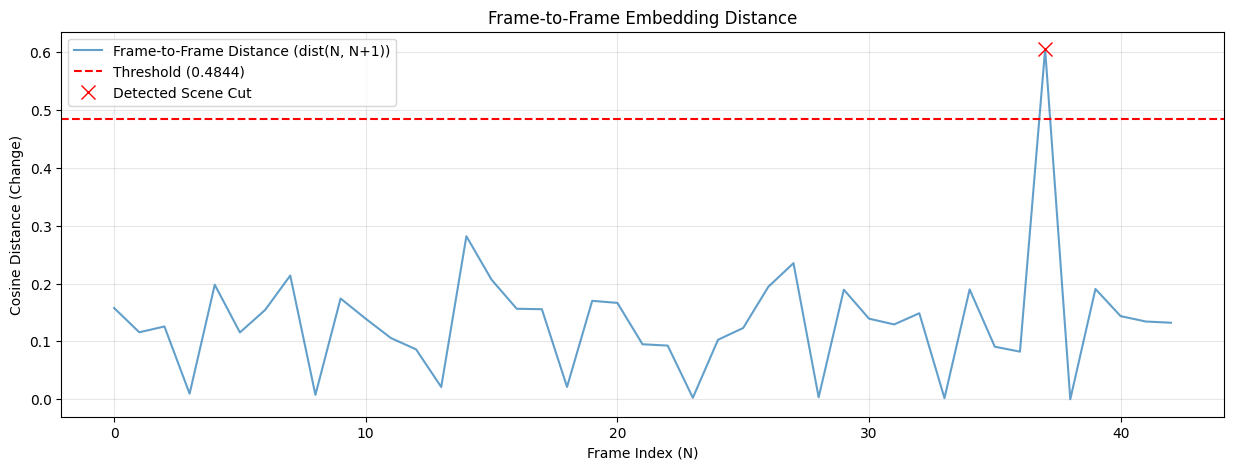


--- 컷 프레임 이미지 ---


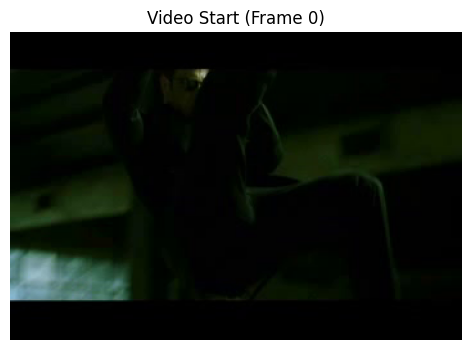

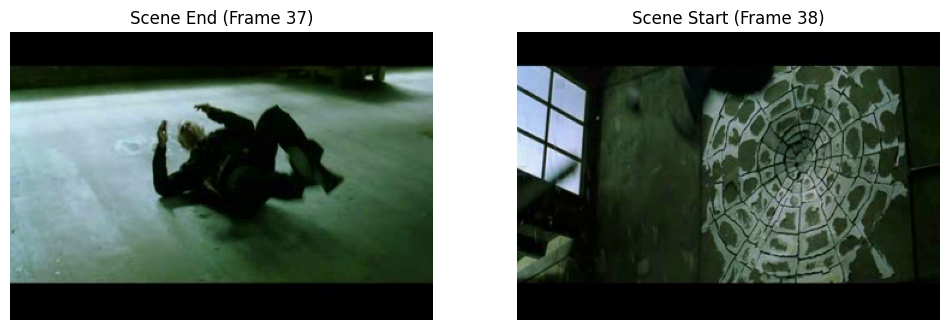

In [5]:
import time
import os
import cv2
import matplotlib.pyplot as plt

if 'video_files' in globals() and video_files:
    test_video_path = video_files[1527]
    print(f"테스트 비디오 시작: {os.path.basename(test_video_path)}")
    
    start_time = time.time()
    
    frame_distances = get_frame_distances(test_video_path)
    
    mid_time = time.time()
    print(f"  임베딩/거리 계산 완료 (총 {len(frame_distances) + 1} 프레임). 소요 시간: {mid_time - start_time:.2f}초")
    
    scene_cuts, threshold = find_scenes_from_distances(frame_distances, multiplier=3.5)
    
    end_time = time.time()
    
    print(f"  씬 감지 완료. (동적 Threshold: {threshold:.4f})")
    print(f"  총 {len(scene_cuts)}개의 씬 컷을 감지했습니다.")
    print(f"  컷 프레임 위치: {scene_cuts}")

    print("\n--- 프레임 간 거리(변화량) 그래프 ---")
    if frame_distances:
        plt.figure(figsize=(15, 5))
        
        # 1. 전체 거리 그래프
        plt.plot(frame_distances, label='Frame-to-Frame Distance (dist(N, N+1))', alpha=0.7)
        
        # 2. Threshold 선
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
        
        # 3. 씬 컷 지점 표시 (빨간 'x')
        cut_indices = [c - 1 for c in scene_cuts]
        cut_values = [frame_distances[i] for i in cut_indices]
        plt.plot(cut_indices, cut_values, 'rx', markersize=10, label='Detected Scene Cut')
        
        plt.title('Frame-to-Frame Embedding Distance')
        plt.xlabel('Frame Index (N)')
        plt.ylabel('Cosine Distance (Change)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("  (거리 데이터가 없어 그래프를 표시할 수 없습니다.)")

    print("\n--- 컷 프레임 이미지 ---")
    
    cap = cv2.VideoCapture(test_video_path)
    if not cap.isOpened():
        print("  오류: 비디오를 열 수 없습니다.")
    else:
        # 1. 첫 프레임 시각화
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, first_frame = cap.read()
        if ret:
            first_frame_rgb = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(6, 4))
            plt.imshow(first_frame_rgb)
            plt.title(f"Video Start (Frame 0)")
            plt.axis('off')
            plt.show()
        else:
            print("  (첫 프레임을 읽을 수 없습니다.)")

        # 2. 씬 컷 프레임 시각화
        if not scene_cuts:
            print("  (감지된 컷이 없습니다.)")
        else:
            for cut_frame in scene_cuts:
                cap.set(cv2.CAP_PROP_POS_FRAMES, cut_frame - 1)
                
                ret1, frame_before = cap.read()
                ret2, frame_after = cap.read()
                
                if ret1 and ret2:
                    frame_before_rgb = cv2.cvtColor(frame_before, cv2.COLOR_BGR2RGB)
                    frame_after_rgb = cv2.cvtColor(frame_after, cv2.COLOR_BGR2RGB)
                    
                    plt.figure(figsize=(12, 5))
                    
                    plt.subplot(1, 2, 1)
                    plt.imshow(frame_before_rgb)
                    plt.title(f"Scene End (Frame {cut_frame - 1})")
                    plt.axis('off')
                    
                    plt.subplot(1, 2, 2)
                    plt.imshow(frame_after_rgb)
                    plt.title(f"Scene Start (Frame {cut_frame})")
                    plt.axis('off')
                    
                    plt.show()
                else:
                    print(f"  {cut_frame} 위치의 프레임을 읽는 데 실패했습니다.")
        
        cap.release()
else:
    print("Cell 3을 먼저 실행하여 video_files 목록을 만드세요.")

In [6]:
import numpy as np
from scipy.signal import find_peaks

def find_scenes_from_distances(distances, prominence=0.2, min_height=0.0):
    scene_cuts = []
    dynamic_threshold_info = f"SciPy find_peaks (prominence={prominence})"

    if not distances or len(distances) < 2:
        return scene_cuts, dynamic_threshold_info

    distances_arr = np.array(distances)

    peak_indices, properties = find_peaks(
        distances_arr, 
        prominence=prominence, 
        height=min_height
    )

    scene_cuts = (peak_indices + 1).tolist()
    
    return scene_cuts, dynamic_threshold_info

테스트 비디오 시작: Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np1_ri_med_3.avi
  임베딩/거리 계산 완료 (총 158 프레임). 소요 시간: 1.23초
  씬 감지 완료. (SciPy find_peaks (prominence=0.2))
  총 4개의 씬 컷을 감지했습니다.
  컷 프레임 위치: [64, 66, 68, 71]

--- 프레임 간 거리(변화량) 그래프 ---


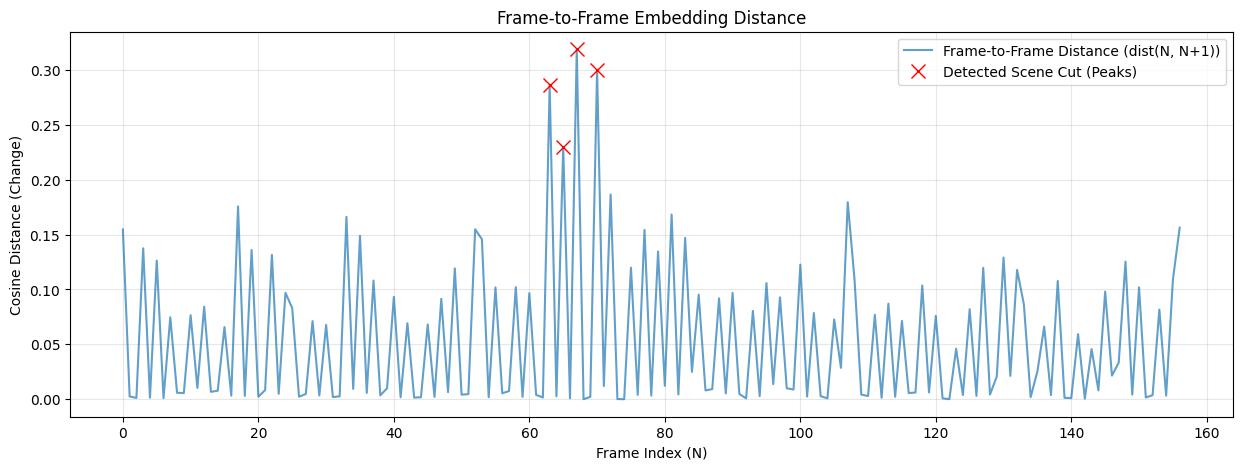


--- 컷 프레임 이미지 ---


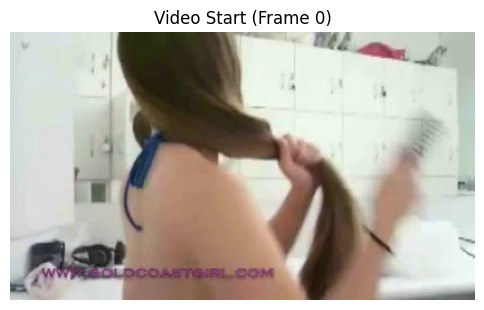

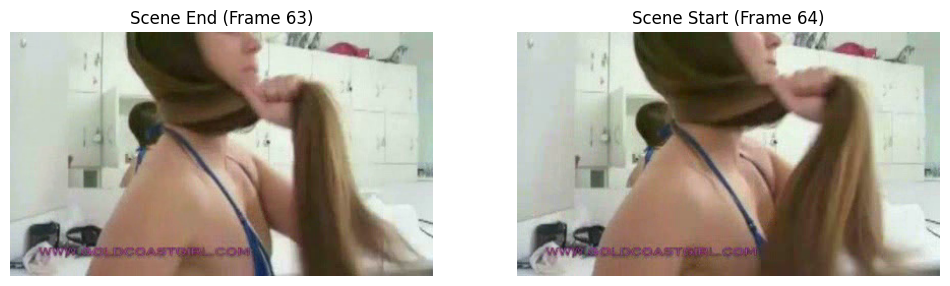

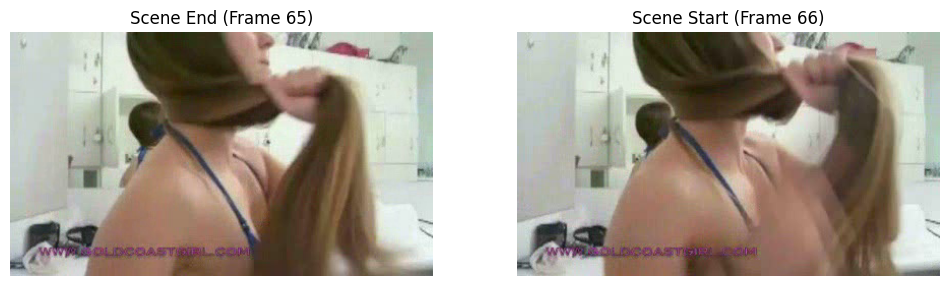

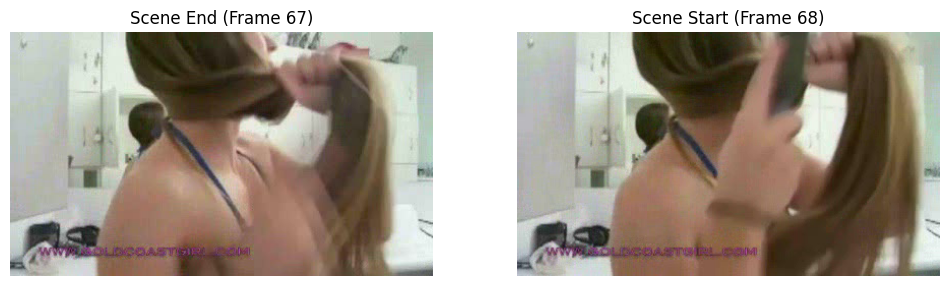

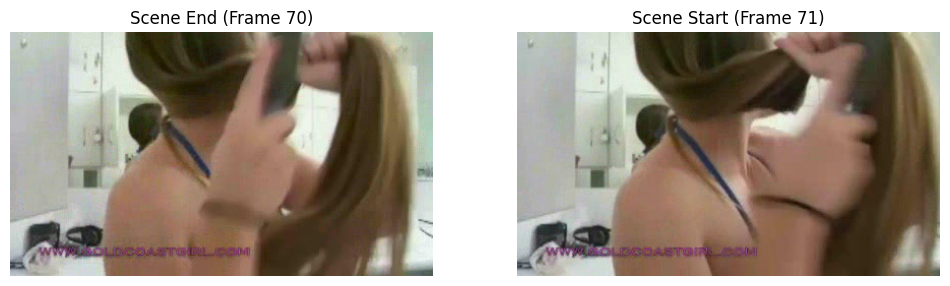

In [ ]:
import time
import os
import cv2
import matplotlib.pyplot as plt

if 'video_files' in globals() and video_files:
    test_video_path = video_files[1527]
    print(f"테스트 비디오 시작: {os.path.basename(test_video_path)}")
    
    start_time = time.time()
    
    frame_distances = get_frame_distances(test_video_path)
    
    mid_time = time.time()
    print(f"  임베딩/거리 계산 완료 (총 {len(frame_distances) + 1} 프레임). 소요 시간: {mid_time - start_time:.2f}초")
    
    scene_cuts, detection_info = find_scenes_from_distances(frame_distances, prominence=0.2)
    
    end_time = time.time()
    
    print(f"  씬 감지 완료. ({detection_info})")
    print(f"  총 {len(scene_cuts)}개의 씬 컷을 감지했습니다.")
    print(f"  컷 프레임 위치: {scene_cuts}")

    print("\n--- 프레임 간 거리(변화량) 그래프 ---")
    if frame_distances:
        plt.figure(figsize=(15, 5))
        
        plt.plot(frame_distances, label='Frame-to-Frame Distance (dist(N, N+1))', alpha=0.7)
        
        cut_indices = [c - 1 for c in scene_cuts]
        cut_values = [frame_distances[i] for i in cut_indices]
        plt.plot(cut_indices, cut_values, 'rx', markersize=10, label='Detected Scene Cut (Peaks)')
        
        plt.title('Frame-to-Frame Embedding Distance')
        plt.xlabel('Frame Index (N)')
        plt.ylabel('Cosine Distance (Change)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("  (거리 데이터가 없어 그래프를 표시할 수 없습니다.)")

    print("\n--- 컷 프레임 이미지 ---")
    
    cap = cv2.VideoCapture(test_video_path)
    if not cap.isOpened():
        print("  오류: 비디오를 열 수 없습니다.")
    else:
        # 1. 첫 프레임 시각화
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, first_frame = cap.read()
        if ret:
            first_frame_rgb = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(6, 4))
            plt.imshow(first_frame_rgb)
            plt.title(f"Video Start (Frame 0)")
            plt.axis('off')
            plt.show()
        else:
            print("  (첫 프레임을 읽을 수 없습니다.)")

        # 2. 씬 컷 프레임 시각화
        if not scene_cuts:
            print("  (감지된 컷이 없습니다.)")
        else:
            for cut_frame in scene_cuts:
                cap.set(cv2.CAP_PROP_POS_FRAMES, cut_frame - 1)
                
                ret1, frame_before = cap.read()
                ret2, frame_after = cap.read()
                
                if ret1 and ret2:
                    frame_before_rgb = cv2.cvtColor(frame_before, cv2.COLOR_BGR2RGB)
                    frame_after_rgb = cv2.cvtColor(frame_after, cv2.COLOR_BGR2RGB)
                    
                    plt.figure(figsize=(12, 5))
                    
                    plt.subplot(1, 2, 1)
                    plt.imshow(frame_before_rgb)
                    plt.title(f"Scene End (Frame {cut_frame - 1})")
                    plt.axis('off')
                    
                    plt.subplot(1, 2, 2)
                    plt.imshow(frame_after_rgb)
                    plt.title(f"Scene Start (Frame {cut_frame})")
                    plt.axis('off')
                    
                    plt.show()
                else:
                    print(f"  {cut_frame} 위치의 프레임을 읽는 데 실패했습니다.")
        
        cap.release()
else:
    print("Cell 3을 먼저 실행하여 video_files 목록을 만드세요.")

In [10]:
from tqdm.notebook import tqdm
import time
import os

if 'video_files' in globals() and callable(get_frame_distances):
    all_scene_results = {}
    total_start_time = time.time()
    
    print(f"총 {len(video_files)}개의 비디오 처리를 시작합니다. (GPU: {device})")
    print("경고: 이 작업은 모든 프레임의 임베딩을 계산하므로 매우 오래 걸립니다.")
    
    for video_path in tqdm(video_files):
        try:
            distances = get_frame_distances(video_path)
            scene_cuts, _ = find_scenes_from_distances(distances, prominence=0.2)
            all_scene_results[os.path.basename(video_path)] = scene_cuts
        except Exception as e:
            print(f"'{video_path}' 처리 중 오류: {e}")
            all_scene_results[os.path.basename(video_path)] = f"Error: {e}"

    total_end_time = time.time()
    print(f"\n모든 비디오 처리 완료. 총 소요 시간: {(total_end_time - total_start_time) / 60:.2f} 분")
    
    print("\n--- 처리 결과 요약 (처음 5개) ---")
    for i, (path_key, cuts) in enumerate(list(all_scene_results.items())[:5]):
        print(f"[{path_key}]: {len(cuts)}개 씬 컷 감지")
else:
    print("Cell 3, 5, 6을 먼저 실행하세요.")

총 6766개의 비디오 처리를 시작합니다. (GPU: cuda)
경고: 이 작업은 모든 프레임의 임베딩을 계산하므로 매우 오래 걸립니다.


  0%|          | 0/6766 [00:00<?, ?it/s]


모든 비디오 처리 완료. 총 소요 시간: 79.94 분

--- 처리 결과 요약 (처음 5개) ---
[April_09_brush_hair_u_nm_np1_ba_goo_0.avi]: 0개 씬 컷 감지
[April_09_brush_hair_u_nm_np1_ba_goo_1.avi]: 0개 씬 컷 감지
[April_09_brush_hair_u_nm_np1_ba_goo_2.avi]: 0개 씬 컷 감지
[atempting_to_brush_my_hair_brush_hair_u_nm_np2_le_goo_0.avi]: 0개 씬 컷 감지
[atempting_to_brush_my_hair_brush_hair_u_nm_np2_le_goo_1.avi]: 0개 씬 컷 감지


In [11]:
import json

if 'all_scene_results' in globals():
    output_json_path = 'hmdb51_embedding_scene_cuts.json'
    
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(all_scene_results, f, indent=4, ensure_ascii=False)
    
    print(f"씬 감지 결과를 '{output_json_path}' 파일에 저장했습니다.")
else:
    print("Cell 8을 먼저 실행하여 'all_scene_results'를 생성하세요.")

씬 감지 결과를 'hmdb51_embedding_scene_cuts.json' 파일에 저장했습니다.
